In [21]:
!pip install --upgrade lightgbm

## **Import libraries**

In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import pickle
import lightgbm as lgb

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## **Load datasets**

In [24]:
train_path = 'train_bbri.csv'
val_path   = 'val_bbri.csv'
test_path  = 'test_bbri.csv'

for p in [train_path, val_path, test_path]:
    if not os.path.exists(p):
        raise FileNotFoundError(f"File not found: {p}. Please upload it to the working directory.")

df_train = pd.read_csv(train_path)
df_val   = pd.read_csv(val_path)
df_test  = pd.read_csv(test_path)

print(f"Shape Train: {df_train.shape}")
print(f"Shape Val:   {df_val.shape}")
print(f"Shape Test:  {df_test.shape}")

# Store test dates before dropping date column (for plotting)
if 'date' in df_test.columns:
    test_dates = pd.to_datetime(df_test['date']).dt.date
else:
    test_dates = None

Shape Train: (977, 17)
Shape Val:   (209, 17)
Shape Test:  (211, 17)


## **Prepare X,y (drop date and target)**

In [25]:
target_col = 'close'
drop_cols = ['date', target_col] if 'date' in df_train.columns else [target_col]

# Feature columns = all except date & close
feature_cols = [c for c in df_train.columns if c not in drop_cols]
print("Feature columns (count={}):".format(len(feature_cols)), feature_cols)

X_train = df_train[feature_cols].copy()
y_train = df_train[target_col].copy()

X_val = df_val[feature_cols].copy()
y_val = df_val[target_col].copy()

X_test = df_test[feature_cols].copy()
y_test = df_test[target_col].copy()

Feature columns (count=15): ['high', 'low', 'open', 'volume', 'MA7', 'MA14', 'MA30', 'returns', 'RSI14', 'MACD', 'MACD_signal', 'MACD_hist', 'lag1', 'lag3', 'lag7']


## **Scaling (fit only on train)**

In [26]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Fit on train only
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

# For deep learning targets we scale y; for LightGBM we'll use original y (unscaled)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled   = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled  = scaler_y.transform(y_test.values.reshape(-1, 1))

# Save scalers (pack)
scaler_pack = {'scaler_X': scaler_X, 'scaler_y': scaler_y}
joblib.dump(scaler_pack, 'scaler_pack.pkl')
print("Saved scaler_pack.pkl")

Saved scaler_pack.pkl


## **Create sequences for deep learning**

In [27]:

# timesteps = 1 (default), or larger (e.g., 14, 30) for sequence models

def create_sequences(X, y, timesteps=1):
    """
    X: 2D array (samples, features)
    y: 2D array (samples, 1)
    returns X_seq (samples', timesteps, features), y_seq (samples', 1)
    """
    if timesteps <= 1:
        # Reshape to (samples, 1, features)
        return X.reshape((X.shape[0], 1, X.shape[1])), y
    Xs, ys = [], []
    for i in range(timesteps, len(X)):
        Xs.append(X[i-timesteps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# Set timesteps (change to >1 if you want sequence input, but ensure enough data)
timesteps = 1  # default 1 (works with lag features). For better performance consider 14/30.
print("Using timesteps =", timesteps)

X_train_dl, y_train_dl = create_sequences(X_train_scaled, y_train_scaled, timesteps=timesteps)
X_val_dl,   y_val_dl   = create_sequences(X_val_scaled,   y_val_scaled,   timesteps=timesteps)
X_test_dl,  y_test_dl  = create_sequences(X_test_scaled,  y_test_scaled,  timesteps=timesteps)

print("Shapes DL inputs:", X_train_dl.shape, y_train_dl.shape, X_val_dl.shape, X_test_dl.shape)

# For LightGBM we use 2D arrays (samples, features) and original y (not scaled)
# If timesteps >1 you might choose to aggregate features for ML model; here we keep original flattened X.
X_train_lgb = X_train_scaled.copy()
X_val_lgb   = X_val_scaled.copy()
X_test_lgb  = X_test_scaled.copy()

# y for LightGBM (unscaled) - use original y values (not scaled)
y_train_lgb = y_train.values
y_val_lgb   = y_val.values
y_test_lgb  = y_test.values

Using timesteps = 1
Shapes DL inputs: (977, 1, 15) (977, 1) (209, 1, 15) (211, 1, 15)


## **Build & Train Deep Learning models**

In [28]:
# Helper to build BiLSTM
def build_bilstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Dropout(0.2),
        Bidirectional(LSTM(32)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Helper to build GRU
def build_gru(input_shape):
    model = Sequential([
        GRU(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(32),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

input_shape = (X_train_dl.shape[1], X_train_dl.shape[2])  # (timesteps, n_features)
print("Input shape for DL models:", input_shape)

# BiLSTM
model_bilstm = build_bilstm(input_shape)
model_bilstm.summary()

# ModelCheckpoint to save best weights during training (optional)
checkpoint_bilstm = ModelCheckpoint('tmp_bilstm_best.h5', save_best_only=True, monitor='val_loss', mode='min')
es = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history_bilstm = model_bilstm.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs=50,
    batch_size=32,
    callbacks=[es, checkpoint_bilstm],
    verbose=1
)

# Save final best BiLSTM model
model_bilstm.save('model_bilstm.h5')
print("Saved model_bilstm.h5")

# GRU
model_gru = build_gru(input_shape)
model_gru.summary()

checkpoint_gru = ModelCheckpoint('tmp_gru_best.h5', save_best_only=True, monitor='val_loss', mode='min')
history_gru = model_gru.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs=50,
    batch_size=32,
    callbacks=[es, checkpoint_gru],
    verbose=1
)
model_gru.save('model_gru.h5')
print("Saved model_gru.h5")

Input shape for DL models: (1, 15)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 1, 128)         │        40,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,289 (329.25 KB)

 Trainable params: 84,289 (329.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1854

31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.1683 - val_loss: 0.0099
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0112

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0111 - val_loss: 0.0026
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0040 - val_loss: 6.4693e-04
Epoch 4/50
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - val_loss: 6.2689e-04
Epoch 5/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - val_loss: 3.9871e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - val_loss: 4.4471e-04
Epoch 7/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0025 - val_loss: 3.5572e-04
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - val_loss: 3.7185e-04
Epoch 9/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025 - val_loss: 3.1282e-04
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - val_loss: 4.2706e-04
Epoch 11/50
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021 - val_loss: 2.5775e-04
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - val_loss: 3.0083e-04
Epoch 13/50
23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018 - val_loss: 2.5259e-04
Epoch 14/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - val_loss: 5.4131e-04
Epoch 15/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - val_loss: 4.8246e-04
Epoch 16/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - val_loss: 8.6285e-04
Epoch 17/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017 - val_loss: 8.5559e-04
Epoch 18/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016 - val_loss: 3.9532e-04
Epoch 19/50
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0014 - val_loss: 1.9814e-04
Epoch 20/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015 - val_loss: 8.5278e-04
Epoch 21/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0014 - val_loss: 2.3246e-04
Epoch 22/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0015 - val_loss: 2.0841e-04
Epoch 23/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015 - val_loss: 5.1396e-04
Epoch 24/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 25/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 4.5179e-04
Epoch 26/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - val_loss: 5.9429e-04


Saved model_bilstm.h5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 1, 64)          │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,049 (101.75 KB)

 Trainable params: 26,049 (101.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1695

31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.1349 - val_loss: 0.0314
Epoch 2/50
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0139

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0135 - val_loss: 0.0088
Epoch 3/50
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0065 - val_loss: 0.0022
Epoch 4/50
23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0051 - val_loss: 8.8932e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - val_loss: 8.9067e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - val_loss: 0.0023
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - val_loss: 0.0035


Saved model_gru.h5


## **Train LightGBM (on original unscaled target)**

In [33]:
lgb_train = lgb.Dataset(X_train_lgb, label=y_train_lgb)
lgb_val = lgb.Dataset(X_val_lgb, label=y_val_lgb, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

print("Training LightGBM...")

model_lgbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=2000,
    valid_sets=[lgb_train, lgb_val],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)  # pengganti verbose_eval
    ]
)

joblib.dump(model_lgbm, 'model_lightgbm.pkl')
print("Saved model_lightgbm.pkl")

Training LightGBM...
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 73.202	valid_1's rmse: 200.658
[100]	training's rmse: 22.9814	valid_1's rmse: 150.74
[150]	training's rmse: 18.1025	valid_1's rmse: 147.661
Early stopping, best iteration is:
[130]	training's rmse: 19.6756	valid_1's rmse: 144.935
Saved model_lightgbm.pkl


## **Prediction on Test set & Inverse transform where needed**

In [34]:
# DL predictions (scaled) -> inverse transform to original scale
pred_bilstm_scaled = model_bilstm.predict(X_test_dl, verbose=0)
pred_gru_scaled    = model_gru.predict(X_test_dl, verbose=0)

pred_bilstm = scaler_y.inverse_transform(pred_bilstm_scaled.reshape(-1, 1)).reshape(-1)
pred_gru    = scaler_y.inverse_transform(pred_gru_scaled.reshape(-1, 1)).reshape(-1)

# LGBM prediction (direct on original scale)
pred_lgbm = model_lgbm.predict(X_test_lgb)

# y_test actual (original)
y_test_actual = y_test.values.reshape(-1)

## **Evaluation metrics**

In [35]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true==0, np.nan, y_true))) * 100
        mape = np.nan_to_num(mape)
    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'MAPE (%)': mape}

res_bilstm = evaluate_model(y_test_actual, pred_bilstm, 'BiLSTM')
res_gru    = evaluate_model(y_test_actual, pred_gru, 'GRU')
res_lgbm   = evaluate_model(y_test_actual, pred_lgbm, 'LightGBM')

df_results = pd.DataFrame([res_bilstm, res_gru, res_lgbm]).set_index('Model')
print("\nHasil Evaluasi pada Data Test:")
print(df_results)


Hasil Evaluasi pada Data Test:
                RMSE        MAE  MAPE (%)
Model                                    
BiLSTM     56.806488  44.593573  1.152205
GRU       110.609729  84.891235  2.171315
LightGBM   32.299702  24.968967  0.646312


## **Determine best model and save appropriately**

In [36]:
best_model_name = df_results['RMSE'].idxmin()
best_rmse = df_results.loc[best_model_name, 'RMSE']
print(f"\n🏆 MODEL TERBAIK: {best_model_name} (RMSE={best_rmse:.4f})")

if best_model_name == 'BiLSTM':
    # already saved as model_bilstm.h5
    # create a canonical name for frontend inference
    model_bilstm.save('best_model.h5')
    joblib.dump({'type': 'keras', 'name': 'best_model.h5'}, 'best_model_meta.pkl')
    print("Saved best_model.h5 (BiLSTM)")
elif best_model_name == 'GRU':
    model_gru.save('best_model.h5')
    joblib.dump({'type': 'keras', 'name': 'best_model.h5'}, 'best_model_meta.pkl')
    print("Saved best_model.h5 (GRU)")
else:
    joblib.dump(model_lgbm, 'best_model.pkl')
    joblib.dump({'type': 'lightgbm', 'name': 'best_model.pkl'}, 'best_model_meta.pkl')
    print("Saved best_model.pkl (LightGBM)")


🏆 MODEL TERBAIK: LightGBM (RMSE=32.2997)
Saved best_model.pkl (LightGBM)


## **Save additional artifacts for Streamlit**

In [37]:
# Save feature column order
with open('feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)
print("Saved feature_columns.pkl")

# Save evaluation results
df_results.to_csv('model_evaluation_results.csv')
print("Saved model_evaluation_results.csv")

Saved feature_columns.pkl
Saved model_evaluation_results.csv


## **Plot (Actual vs Predicted)**

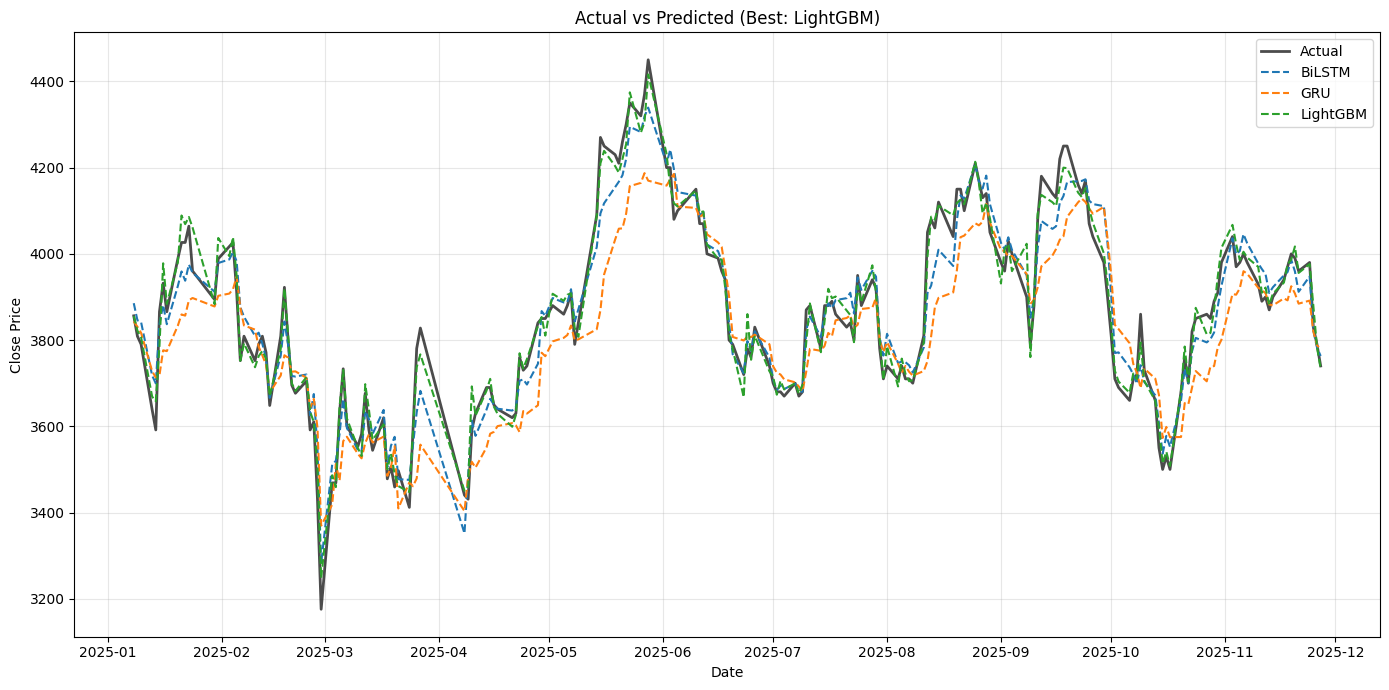

All done. Artifacts saved:
- best_model.* (h5 or pkl)
- best_model_meta.pkl
- scaler_pack.pkl
- feature_columns.pkl
- model_evaluation_results.csv
- prediction_comparison.png


In [38]:
plt.figure(figsize=(14,7))
if test_dates is not None:
    xaxis = test_dates[-len(y_test_actual):]  # align lengths (in case sequence windows changed lengths)
else:
    xaxis = np.arange(len(y_test_actual))

plt.plot(xaxis, y_test_actual, label='Actual', color='black', linewidth=2, alpha=0.7)
plt.plot(xaxis, pred_bilstm, label='BiLSTM', linestyle='--')
plt.plot(xaxis, pred_gru, label='GRU', linestyle='--')
plt.plot(xaxis, pred_lgbm, label='LightGBM', linestyle='--')
plt.title(f'Actual vs Predicted (Best: {best_model_name})')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('prediction_comparison.png', dpi=200)
plt.show()

print("All done. Artifacts saved:")
print("- best_model.* (h5 or pkl)")
print("- best_model_meta.pkl")
print("- scaler_pack.pkl")
print("- feature_columns.pkl")
print("- model_evaluation_results.csv")
print("- prediction_comparison.png")